In [ ]:
!wget 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
!bzip2 -dk '/content/shape_predictor_68_face_landmarks.dat.bz2'

--2020-08-16 14:53:12--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  6.01MB/s    in 35s     

2020-08-16 14:53:48 (1.75 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import dlib
import math

In [ ]:
PREDICTOR_PATH = '/content/shape_predictor_68_face_landmarks.dat'

In [ ]:
face_detector = dlib.get_frontal_face_detector()
face_landmark_predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [ ]:
img = cv2.imread('/content/face.jpeg')

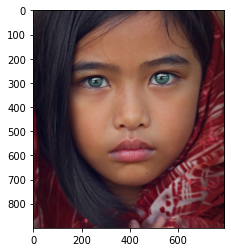

In [ ]:
plt.imshow(img[:,:,::-1])
plt.show()

In [9]:
img = cv2.imread('/content/face.jpeg')
face_rects = face_detector(img, 2)
faces = []

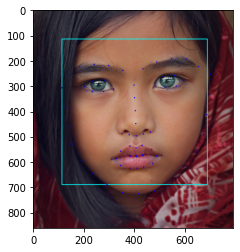

In [ ]:
face_img = img.copy()
H, W, _ = face_img.shape
for i, face_rect in enumerate(face_rects):
  left, top, right, bottom = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()

  rect = dlib.rectangle(left, top, right, bottom)
  landmarks = face_landmark_predictor(img, rect)

  top_left = (left, top)
  bottom_right = (right, bottom)
  
  face_img = cv2.rectangle(face_img, top_left, bottom_right, color=(255, 255, 0), thickness=2) 
  
  border = int(0.3 * min(abs(top - bottom), abs(left - right)))
  top_crop = top - border if top - border > 0 else 0
  bottom_crop = bottom + border if bottom + border < H else H 
  left_crop = left - border if left - border > 0 else 0
  right_crop = right + border if right + border < W else W

  img_rect = face_img[top_crop:bottom_crop, left_crop:right_crop]

  landmarks_offsetted = []
  for i, landmark in enumerate(landmarks.parts()):
    x, y, = landmark.x - left_crop, landmark.y - top_crop
    landmarks_offsetted.append((x, y))
    img_rect = cv2.circle(img_rect, (x, y), radius=1, color=(255, 0, 0), thickness=2)

  # print(abs(left - right), abs(top - bottom))
  # print(img_rect.shape)
  plt.figure()
  plt.imshow(img_rect[:,:,::-1])
  faces.append({'idx': i, 
                'rect_xy': (left, top, right, bottom), 
                'rect_xy_offsetted': (left_crop, top_crop, right_crop, bottom_crop), 
                'landmarks_offsetted': landmarks_offsetted,
                'landmarks': landmarks.parts(),
                'rect': img[top_crop:bottom_crop, left_crop:right_crop]})

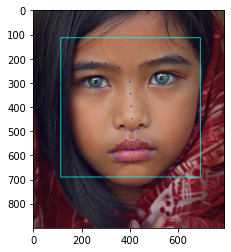

In [ ]:
plt.imshow(face_img[:,:,::-1])
plt.show()

In [ ]:
def get_faces(img, face_detector, face_landmark_predictor):
  face_rects = face_detector(img, 2)
  faces = []
  
  face_img = img.copy()
  H, W, _ = face_img.shape
  for i, face_rect in enumerate(face_rects):
    left, top, right, bottom = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()

    rect = dlib.rectangle(left, top, right, bottom)
    landmarks = face_landmark_predictor(img, rect)

    top_left = (left, top)
    bottom_right = (right, bottom)
    
    face_img = cv2.rectangle(face_img, top_left, bottom_right, color=(255, 255, 0), thickness=2) 
    
    border = int(2 * min(abs(top - bottom), abs(left - right)))
    top_crop = top - border if top - border > 0 else 0
    bottom_crop = bottom + border if bottom + border < H else H 
    left_crop = left - border if left - border > 0 else 0
    right_crop = right + border if right + border < W else W

    img_rect = face_img[top_crop:bottom_crop, left_crop:right_crop]

    landmarks_offsetted = []
    landmarks_actual = []
    for i, landmark in enumerate(landmarks.parts()):
      x, y, = landmark.x, landmark.y
      landmarks_actual.append((x, y))
      landmarks_offsetted.append((x, y))
      img_rect = cv2.circle(img_rect, (x, y), radius=1, color=(255, 0, 0), thickness=2)

    faces.append({'idx': i, 
                  'rect_xy': (left, top, right, bottom), 
                  'rect_xy_offsetted': (left_crop, top_crop, right_crop, bottom_crop), 
                  'landmarks_offsetted': landmarks_offsetted,
                  'landmarks': landmarks_actual,
                  'img': img,
                  'rect': img[top_crop:bottom_crop, left_crop:right_crop]})
    
    return faces

# Face alignment

In [ ]:
# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalize_images_and_landmarks(out_size, img_in, points_in):
  h, w = out_size

  # Corners of the eye in input image
  eyecorner_src = [points_in[36], points_in[45]]

  # Corners of the eye in normalized image
  eyecorner_dst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]
  
  # Calculate similarity transform
  tform = similarity_transform(eyecorner_src, eyecorner_dst)

  # Apply similarity transform to input image
  img_out = cv2.warpAffine(img_in, tform, (w, h))

  # reshape points_in from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(points_in, (points_in.shape[0], 1, points_in.shape[1]))
  
  # Apply similarity transform to landmarks
  points_out = cv2.transform(points2, tform)

  # reshape points_out to numLandmarks x 2
  points_out = np.reshape(points_out, (points_in.shape[0], points_in.shape[1]))

  return img_out, points_out

In [ ]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarity_transform(in_points, out_points):
  s60 = math.sin(60 * math.pi / 180)
  c60 = math.cos(60 * math.pi / 180)

  in_pts = np.copy(in_points).tolist()
  out_pts = np.copy(out_points).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(in_pts[0][0] - in_pts[1][0]) - s60*(in_pts[0][1] - in_pts[1][1]) + in_pts[1][0]
  yin = s60*(in_pts[0][0] - in_pts[1][0]) + c60*(in_pts[0][1] - in_pts[1][1]) + in_pts[1][1]

  in_pts.append([np.int(xin), np.int(yin)])

  xout = c60*(out_pts[0][0] - out_pts[1][0]) - s60*(out_pts[0][1] - out_pts[1][1]) + out_pts[1][0]
  yout = s60*(out_pts[0][0] - out_pts[1][0]) + c60*(out_pts[0][1] - out_pts[1][1]) + out_pts[1][1]

  out_pts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  # tform = cv2.estimateRigidTransform(np.array([in_pts]), np.array([out_pts]), False)
  tform, _ = cv2.estimateAffinePartial2D(np.array([in_pts]), np.array([out_pts]), False)

  # tform = cv2.getAffineTransform(eyecorner_src, eyecorner_dst)
  # tform = cv2.getAffineTransform(np.array([in_pts], dtype=np.float32), np.array([out_pts], dtype=np.float32))
  return tform

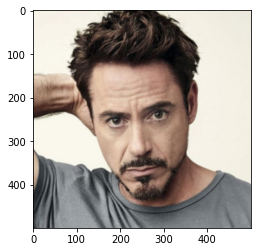

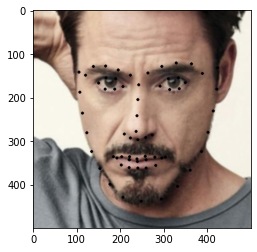

In [ ]:
img = cv2.imread('/content/rdj.jpg')
faces = get_faces(img, face_detector, face_landmark_predictor)
face_extracted = faces[0]
h, w, _ = face_extracted['img'].shape
face_in = np.float32(face_extracted['img']) / 255.0
img_out, points_out = normalize_images_and_landmarks((h, w), face_in, np.array(face_extracted['landmarks']))

for i, (x, y) in enumerate(points_out):
  img_rect = cv2.circle(img_out, (x, y), radius=2, color=(255, 0, 0), thickness=2)

plt.figure()
plt.imshow(img[:, :, ::-1])
plt.figure()
plt.imshow(np.uint8(img_rect[:, :, ::-1] * 255))

# Face Swap

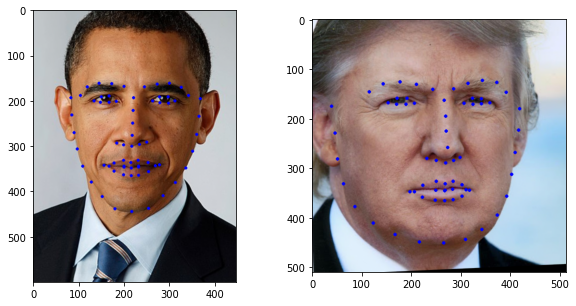

In [ ]:
img_src = cv2.imread('/content/obama.jpg')
img_target = cv2.imread('/content/trump.jpg')

def get_aligned_faces(img):
  faces = get_faces(img, face_detector, face_landmark_predictor)
  face_extracted = faces[0]
  h, w, _ = face_extracted['img'].shape
  face_in = np.float32(face_extracted['img']) / 255.0
  img_out, points_out = normalize_images_and_landmarks((h, w), face_in, np.array(face_extracted['landmarks']))
  img_out = np.uint8(img_out * 255)
  return img_out, points_out

img_src, points_src = get_aligned_faces(img_src)
img_target, points_target = get_aligned_faces(img_target)

img_rect = img_src.copy()
for i, (x, y) in enumerate(points_src):
  img_rect = cv2.circle(img_rect, (x, y), radius=2, color=(255, 0, 0), thickness=2)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_rect[:, :, ::-1])

img_rect = img_target.copy()
for i, (x, y) in enumerate(points_target):
  img_rect = cv2.circle(img_rect, (x, y), radius=2, color=(255, 0, 0), thickness=2)
plt.subplot(122)
plt.imshow(img_rect[:, :, ::-1])

In [ ]:
# Find convex hull
hull_target_index = cv2.convexHull(np.array(points_target), returnPoints=False)

# Create convex hull lists
hull_src = []
hull_target = []
for i in range(0, len(hull_target_index)):
    hull_src.append(points_src[hull_target_index[i][0]])
    hull_target.append(points_target[hull_target_index[i][0]])

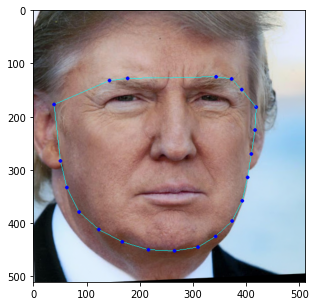

In [ ]:
# Display Convex Hull
im_temp = img_target.copy()
num_points = len(hull_target)
for i in range(0, num_points):
    x1, y1 = hull_target[i]
    x2, y2 = hull_target[(i + 1) % num_points]
    cv2.line(im_temp, (x1, y1), (x2, y2), color=(255, 255, 0), thickness=1)
    cv2.circle(im_temp, (x1, y1), radius=2, color=(255, 0, 0), thickness=2)

plt.figure(figsize=(5, 5)); 
plt.imshow(im_temp[:, :, ::-1]);

In [ ]:
# Calculate Mask for Seamless cloning
hull_points = []
for i in range(0, len(hull_target)):
    hull_points.append((hull_target[i][0], hull_target[i][1]))

mask = np.zeros(img_target.shape, dtype=img_target.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull_points), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

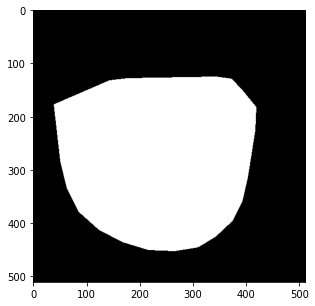

In [ ]:
# Display Mask
plt.figure(figsize = (5, 5));
plt.imshow(mask);

In [ ]:
# Find Delaunay traingulation for convex hull points
size_target = img_target.shape    
rect = (0, 0, size_target[1], size_target[0])
dt = calculate_delaunay_triangles(rect, hull_target)
print(f'{len(dt)} delaunay triangles found')

19 delaunay triangles found


In [ ]:
img_src_temp = img_src.copy()
img_target_temp = img_target.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull_src[dt[i][j]])
        tri2.append(hull_target[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(img_src_temp, np.array(tris1), True, (0,0,255), 2);
cv2.polylines(img_target_temp, np.array(tris2), True, (0,0,255), 2);

(-0.5, 511.5, 510.5, -0.5)

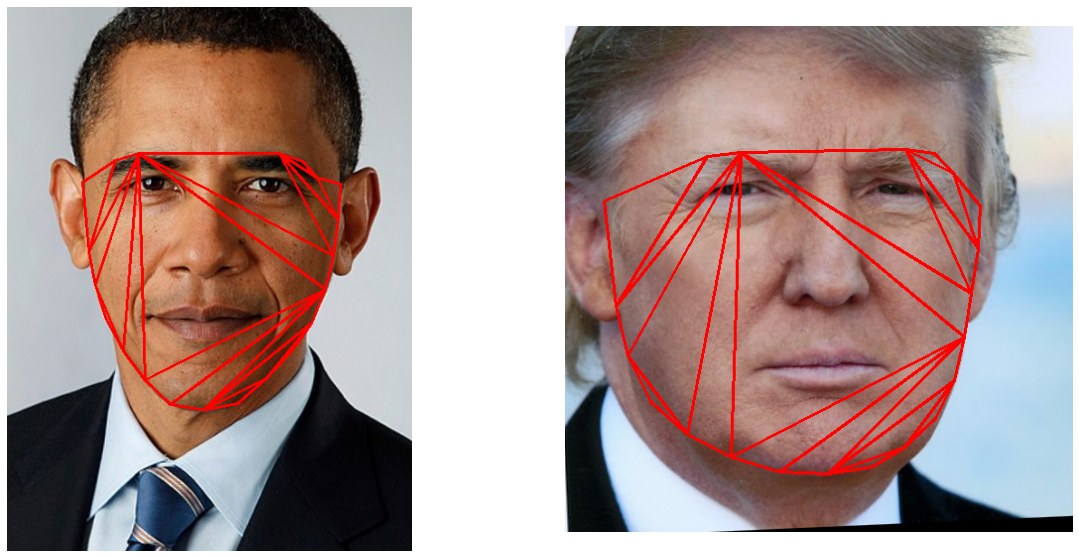

In [ ]:
# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121)
plt.imshow(img_src_temp[:, :, ::-1])
plt.axis('off')
plt.subplot(122)
plt.imshow(img_target_temp[:, :, ::-1])
plt.axis('off')

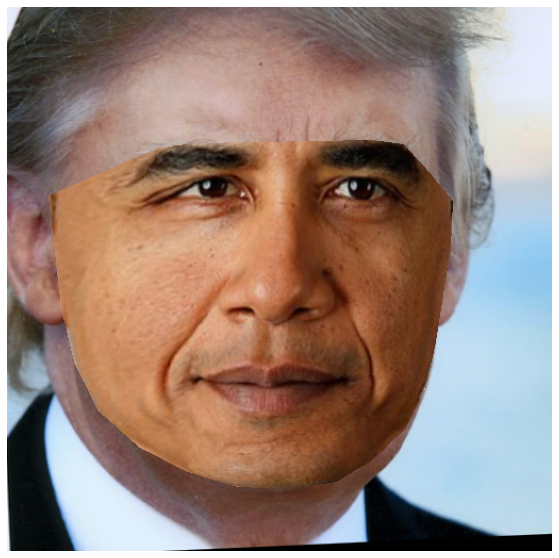

In [ ]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles

img_src_warped = np.copy(img_target)
for i in range(0, len(tris1)):
    warp_triangle(img_src, img_src_warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img_src_warped)[:,:,::-1])
plt.axis('off');

In [ ]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img_src_warped), img_target, mask, center, cv2.NORMAL_CLONE)

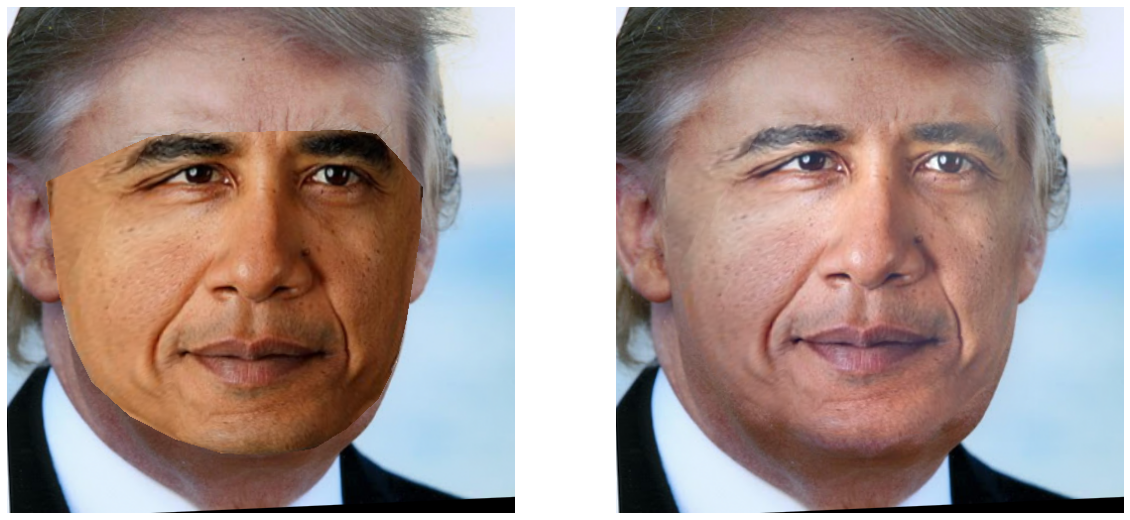

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img_src_warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

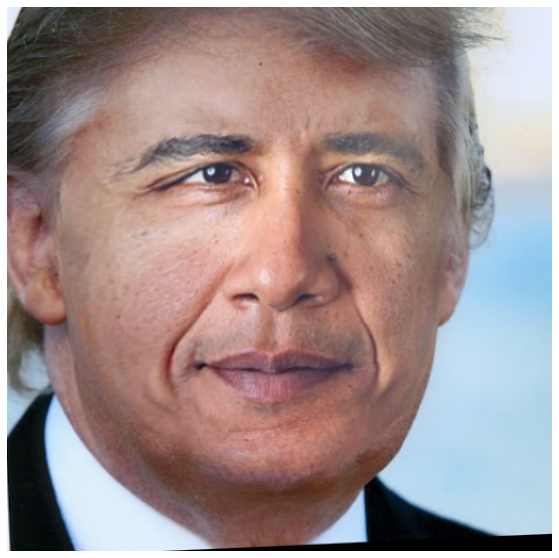

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(output[:,:,::-1]); plt.axis('off');

In [ ]:
# Check if a point is inside a rectangle
def rect_contains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True

In [ ]:
# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculate_delaunay_triangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangle_list = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunay_tri = []

  for t in triangle_list:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunay_tri.append((ind[0], ind[1], ind[2]))

  return delaunay_tri

In [ ]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warp_triangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1_rect = []
  t2_rect = []
  t2_rect_int = []

  for i in range(0, 3):
    t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2_rect_int.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2_rect_int), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2_rect = apply_affine_transform(img1_rect, t1_rect, t2_rect, size)

  img2_rect = img2_rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2_rect

In [ ]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def apply_affine_transform(src, src_tri, dst_tri, size):

  # Given a pair of triangles, find the affine transform.
  warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst